## Importando bibliotecas e dados

In [1]:
import pandas as pd
from itertools import compress
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, ElasticNetCV
from sklearn.feature_selection import RFE, RFECV
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


## Função de resultados

In [2]:
def get_results_cv_fit(model, scaling_y, X, y):
    X_columns = list(X.columns)
    y_columns = list(y.columns)
    metrics_dict = {}
    
    cv_r2 = {'train':[],'test':[]}
    cv_r2a = {'train':[],'test':[]}
    cv_rmse = {'train':[],'test':[]}
    cv_mae = {'train':[],'test':[]}
    cv_in_std = {'train':[],'test':[]}

    kf = KFold(n_splits=2)
    KFold(n_splits=5, random_state=42, shuffle=True)
    
    for train_index, test_index in kf.split(X):
          
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]
        
        model.fit(X_train, y_train.to_numpy().ravel())
        
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

        ## obtendo o y desnormalizado
        y_train_denorm = scaling_y.inverse_transform(y_train)
        y_train_denorm_np = scaling_y.inverse_transform(y_train.to_numpy().reshape(-1, 1)) ## para funções que precisem  do formato numpy
        train_preds_denorm = scaling_y.inverse_transform(train_preds.reshape(-1, 1))
        ##
        y_test_denorm = scaling_y.inverse_transform(y_test)
        y_test_denorm_np = scaling_y.inverse_transform(y_test.to_numpy().reshape(-1, 1)) ## para funções que precisem  do formato numpy
        test_preds_denorm = scaling_y.inverse_transform(test_preds.reshape(-1, 1))
        
        ## calculando as métricas de treinamento
        r2 = r2_score(y_train_denorm, train_preds_denorm)
        n = len(y_train)
        p = X_train.shape[1]
        adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
        mse = mean_squared_error(y_train_denorm, train_preds_denorm)
        rmse = sqrt(mse)
        mae = mean_absolute_error(y_train_denorm, train_preds_denorm)
        y_in_std = np.std(y_train_denorm_np)
        
        ## salvando nos cross_validation_dicts:
        cv_r2['train'].append(r2)
        cv_r2a['train'].append(adj_r2)
        cv_rmse['train'].append(rmse)
        cv_mae['train'].append(mae)
        cv_in_std['train'].append(y_in_std)

        ## calculando as métricas de teste
        r2 = r2_score(y_test_denorm, test_preds_denorm)
        n = len(y_test)
        p = X_test.shape[1]
        adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
        mse = mean_squared_error(y_test_denorm, test_preds_denorm)
        rmse = sqrt(mse)
        mae = mean_absolute_error(y_test_denorm, test_preds_denorm)
        y_in_std = np.std(y_test_denorm_np)
             
        ## salvando nos cross_validation_dicts:
        cv_r2['test'].append(r2)
        cv_r2a['test'].append(adj_r2)
        cv_rmse['test'].append(rmse)
        cv_mae['test'].append(mae)
        cv_in_std['test'].append(y_in_std)
    
    metrics_dict['rmse_treinamento'] = np.mean(cv_rmse['train'])
    metrics_dict['mae_treinamento'] = np.mean(cv_mae['train'])
    metrics_dict['y_in_std_treinamento'] = np.mean(cv_in_std['train'])
    
    metrics_dict['rmse_teste'] = np.mean(cv_rmse['test'])
    metrics_dict['mae_teste'] = np.mean(cv_mae['test'])
    metrics_dict['y_in_std_teste'] = np.mean(cv_in_std['test'])
    metrics_dict['train_test_ratio'] = metrics_dict['rmse_treinamento']/metrics_dict['rmse_teste']
    
    metrics_dict['summary_text'] = summary_text(metrics_dict)
    return metrics_dict

def summary_text(metrics_dict):
    return """
RMSE de treinamento: {:.5f}
MAE de treinamento: {:.5f}
STD input de treinamento: {:.5f}

RMSE de teste: {:.5f}
MAE de teste: {:.5f}
STD input de teste: {:.5f}

Proporção Treino/Teste (RMSE): {:.5f}
    """.format(metrics_dict['rmse_treinamento'], metrics_dict['mae_treinamento'], metrics_dict['y_in_std_treinamento'], metrics_dict['rmse_teste'], metrics_dict['mae_teste'], metrics_dict['y_in_std_teste'],metrics_dict['train_test_ratio'])


## Função do modelo

In [3]:
def forest_model(X_original, y_original):
    x_columns = X_original.columns
    y_columns = y_original.columns
    ############## fazendo o scaling dos dados #####################
    scaling_x = StandardScaler()
    scaling_y = StandardScaler()
    X =scaling_x.fit_transform(X_original)
    y = scaling_y.fit_transform(y_original)

    ############ fazendo o split de dados para o RFE #######################
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
    
    ########### rodando o RFE #############################
    rf = RandomForestRegressor(random_state=0)
    rfe = RFECV(rf,cv=5,scoring="neg_root_mean_squared_error")
    rfe.fit(X_train,y_train.ravel())
    remaining_columns = list(compress(x_columns, list(rfe.support_)))
    x_columns = remaining_columns
    X_new = rfe.transform(X)

    param_grid = {
     'bootstrap':[True, False],
     'max_depth': [2,4,6,8,10],
     'max_features': [0.2,0.4,0.6,0.8,'auto','sqrt'],
     'min_samples_leaf': [2, 4, 8, 16],
     'min_samples_split': [2, 4, 8, 16]
     }
    
    best_train_test_ratio = 0
    best_config = {}
    result_log = []
    
    ########## grid search para os parâmetros escolhidos, otimizando por train_test_ratio (rmse_treino/rmse_teste)
    for bootstrap in param_grid['bootstrap']:
        for max_depth in param_grid['max_depth']:
            for max_features in param_grid['max_features']:
                for min_samples_leaf in param_grid['min_samples_leaf']:
                    for min_samples_split in param_grid['min_samples_split']:
                        model = RandomForestRegressor(random_state=0, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
                        results = get_results_cv_fit(model, scaling_y, pd.DataFrame(X_new,columns = x_columns), pd.DataFrame(y,columns = y_columns))
                        results['bootstrap'] = bootstrap
                        results['max_depth'] = max_depth
                        results['max_features'] = max_features
                        results['min_samples_leaf'] = min_samples_leaf
                        results['min_samples_split'] = min_samples_split

                        feature_importance = list(zip(remaining_columns, model.feature_importances_))
                        feature_importance_features = [x[0] for x in feature_importance]
                        feature_importance_importance = [x[1] for x in feature_importance]
                        new_df = pd.DataFrame({'atributo':feature_importance_features,'importância':feature_importance_importance})
                        new_df = new_df.sort_values('importância',ascending=False)
                        results['feature importance'] = new_df
                        result_log.append(results)
                        pd.DataFrame(result_log)[list(filter(lambda x: not x in ['featureimportance','summary_text'],result_log[0].keys()))].to_csv('./output12.csv')

                        if results['train_test_ratio'] > best_train_test_ratio and results['rmse_teste']<126.21:
                            best_train_test_ratio = results['train_test_ratio']
                            best_config = results

    output = best_config
    output['best params'] = ",".join("{}={}".format(*i) for i in {k: v for k, v in best_config.items() if k in ['bootstrap','max_depth','max_features','min_samples_leaf','min_samples_split']}.items())
    
    return output

## Função de chamadas

In [4]:
def super_func(df_path):
    print("´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´")
    print(df_path)
    model_names = ['Floresta otimizada']
    df_original = pd.read_csv('./'+df_path)
    df_original = df_original.applymap(lambda x: x if type(x) == type(0.0) else str(x).replace(",","."))
    df_original = df_original.rename(columns={'Alita (μm)':'Diâmetro Alita (µm)'})
    df_original = df_original.dropna(axis=0, how='all')
    df = df_original.copy()
    df.columns = [col.strip() for col in df.columns]
    for col in df.columns[:]:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    y_column_name = 'NOx (ppm)'
    out_index = list(df.columns).index(y_column_name)
    X_columns = df.columns[:out_index]
    
    row = {'Dados':df_path}
    
    print('##########################') 
    print(model_names[0])
    output = forest_model(df[X_columns], df[[y_column_name]])
    row[model_names[0]] = output['summary_text']
    row[model_names[0]+' - best params'] = output['best params']
    row[model_names[0]+' - feature importance'] = output['feature importance']
    
    print("Resumo dos resultados: ")
    print(row[model_names[0]])
    print('Melhor combinação de parâmetros: ')
    print(row[model_names[0]+' - best params'])
    print('\nFeature importance: ')
    display(row[model_names[0]+' - feature importance'])
    
    
    return row

In [5]:
final_models_df = pd.DataFrame(columns = ['Dados','Floresta otimizada', 'Floresta otimizada - best params', 'Floresta otimizada - feature importance'])#, 'y_test', 'y_out'])
final_models_df = final_models_df.append(super_func('NOX2 - 4.csv'), ignore_index=True)
final_models_df.to_csv('./output5.csv')
display(final_models_df)

´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´
NOX2 - 4.csv
##########################
Floresta otimizada
Resumo dos resultados: 

RMSE de treinamento: 99.84034
MAE de treinamento: 69.00237
STD input de treinamento: 142.50592

RMSE de teste: 126.17554
MAE de teste: 91.27815
STD input de teste: 142.50592

Proporção Treino/Teste (RMSE): 0.79128
    
Melhor combinação de parâmetros: 
bootstrap=True,max_depth=4,max_features=0.8,min_samples_leaf=16,min_samples_split=2

Feature importance: 


,atributo,importância
14,Temperatura Zona de queima,0.486591
15,Temperatura Ar Secundário,0.079456
6,Momento do Forno - Motor 3 (A),0.044849
20,velocidade do simplex,0.041868
9,Carga térmica,0.040459
4,Ar radial (mmH2O),0.033500
1,Rotação Forno (rpm),0.028385
11,Oxigênio saída Ramal A,0.027956
17,K1 SO3,0.021650
19,∆P lado B,0.017709


,Dados,Floresta otimizada,Floresta otimizada - best params,Floresta otimizada - feature importance
0,NOX2 - 4.csv,\nRMSE de treinamento: 99.84034\nMAE de treina...,"bootstrap=True,max_depth=4,max_features=0.8,mi...",atributo impo...


## Reproduzindo o modelo e plotando gráficos

In [11]:
dados = pd.read_csv('./NOX2 - 4.csv')
dados = dados.applymap(lambda x: x if type(x) == type(0.0) else str(x).replace(",","."))
dados = dados.rename(columns={'Alita (μm)':'Diâmetro Alita (µm)'})
dados = dados.dropna(axis=0, how='all')
dados.columns = [col.strip() for col in dados.columns]
for col in dados.columns[:]:
    dados[col] = pd.to_numeric(dados[col], errors='coerce').fillna(0)

remaining_columns = list(final_models_df.loc[0,'Floresta otimizada - feature importance']['atributo'].values)


############## fazendo o scaling dos dados #####################
scaling_x = StandardScaler()
scaling_y = StandardScaler()
X =scaling_x.fit_transform(dados[remaining_columns])
y = scaling_y.fit_transform(dados[['NOx (ppm)']])

############ fazendo o split de dados para o RFE #######################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=678910)

########### criando e treinando o modelo ##################
model = RandomForestRegressor(random_state=0, max_depth=4, max_features=0.8, min_samples_leaf=16, min_samples_split=2)
model.fit(X_train, y_train.ravel())
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

## obtendo o y desnormalizado
y_train_denorm = scaling_y.inverse_transform(y_train)
y_train_denorm_np = scaling_y.inverse_transform(y_train.reshape(-1, 1)) ## para funções que precisem  do formato numpy
train_preds_denorm = scaling_y.inverse_transform(train_preds.reshape(-1, 1))
##
y_test_denorm = scaling_y.inverse_transform(y_test)
y_test_denorm_np = scaling_y.inverse_transform(y_test.reshape(-1, 1)) ## para funções que precisem  do formato numpy
test_preds_denorm = scaling_y.inverse_transform(test_preds.reshape(-1, 1))


In [25]:
y_test = np.array(y_test_denorm).ravel()
y_out = np.array(test_preds_denorm).ravel()

In [29]:
print(y_test)
print(y_out)

[1147.  614.  776.  794. 1310.  790.  724.  756.  769.  869. 1015.  748.
  920.  951.  768.  813.  725.  703.   59.  979.  846. 1009.  855.  852.
  852.  931.  654. 1058.  692.  563.  757.  767.  870.  798.  735.  800.
  641.  806.  886.  732.  869.  855. 1072.  664.  947.  658.  909.  899.
  678.  764.  778.  770.  960.  859.  743.  891.  787.  708.  785.  921.
  624.  740.  793.  649.  843. 1069.  651.  829.  890.  621.  727.  975.
  900.  760.  819.  800. 1095.  821.  992.  974.  755.  726. 1045.  695.
  774.  806.  687.  711.  818.  670.  721.  897.  719.  731.  818.  989.
  872.  706.  855.  911.  856.  937.  761.  707.  775.  887.  939.  772.
  728.  742.  793.  851.  497.  762.  838.  848.  703.  718.  943.  683.
  804.  770.  675.  898.  949.  949. 1032.  869.  821.  905.  661.  716.
  918.  796.  886.  800.  796.  931.  951.  961. 1128. 1200.  871.  817.
 1057.  906.  706.  821.  749.  834.  753. 1088.  744.  799.  760.  868.
  773.  695.  793.  934.  976.  810.  769.  652.  9

In [26]:
randomized = np.random.normal(loc=np.mean(y_test),scale=np.std(y_test),size=len(y_test))

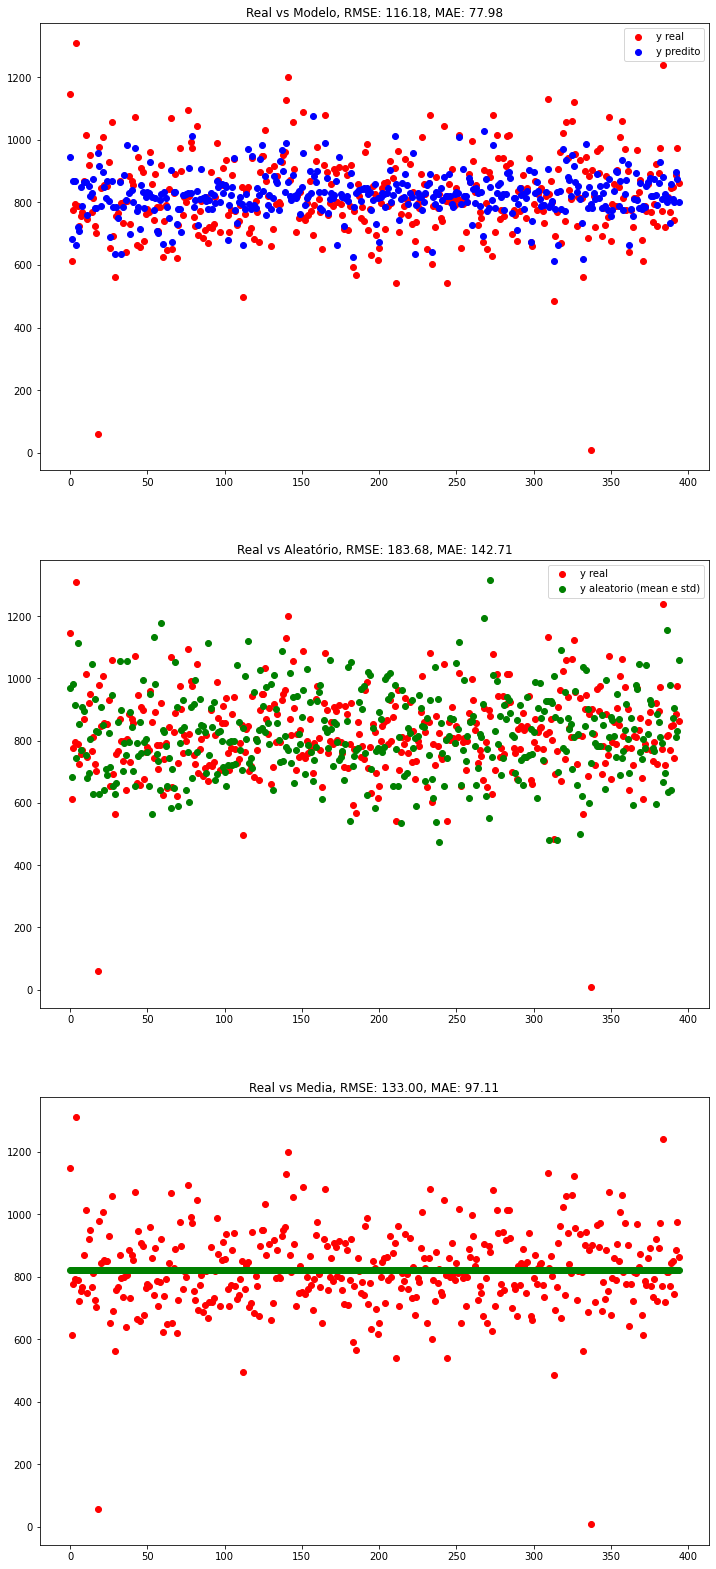

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,28))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.scatter(x=range(len(y_test)), y=y_test, c= 'red', label = 'y real')
ax1.scatter(x=range(len(y_test)), y=y_out, c= 'blue', label = 'y predito')
ax1.set_title('Real vs Modelo, RMSE: {:.2f}, MAE: {:.2f}'.format(sqrt(mean_squared_error(y_test,y_out)),mean_absolute_error(y_test, y_out)))
ax2.scatter(x=range(len(y_test)), y=y_test, c= 'red', label = 'y real')
ax2.scatter(x=range(len(y_test)), y=randomized, c= 'green', label = 'y aleatorio (mean e std)')
ax2.set_title('Real vs Aleatório, RMSE: {:.2f}, MAE: {:.2f}'.format(sqrt(mean_squared_error(y_test,randomized)),mean_absolute_error(y_test, randomized)))
ax3.scatter(x=range(len(y_test)), y=y_test, c= 'red', label = 'y real')
ax3.scatter(x=range(len(y_test)), y=[np.mean(y_test)]*len(y_test), c= 'green', label = 'y media')
ax3.set_title('Real vs Media, RMSE: {:.2f}, MAE: {:.2f}'.format(sqrt(mean_squared_error(y_test,[np.mean(y_test)]*len(y_test))),mean_absolute_error(y_test, [np.mean(y_test)]*len(y_test))))

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.show()

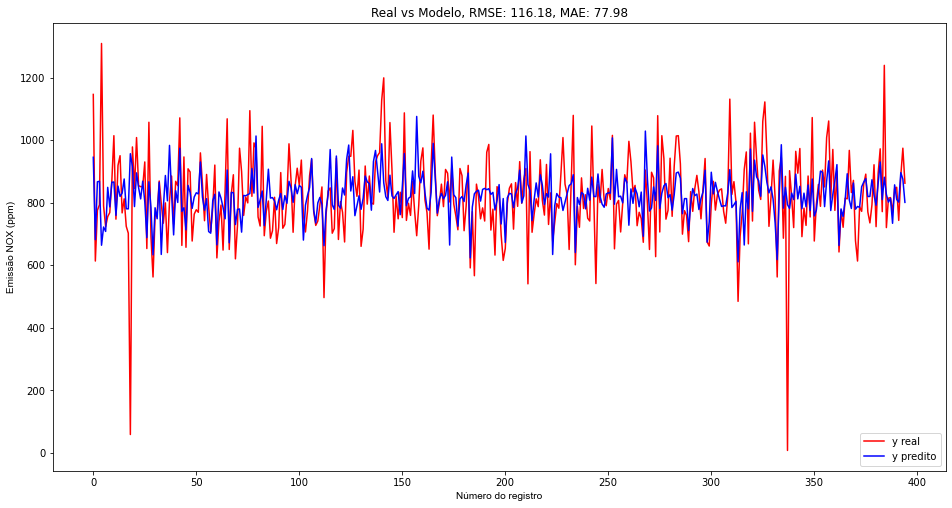

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16,28))
ax1 = fig.add_subplot(311)
ax1.plot(range(len(y_test)), y_test, c= 'red', label = 'y real')
ax1.plot(range(len(y_test)), y_out, c= 'blue', label = 'y predito')
ax1.set_title('Real vs Modelo, RMSE: {:.2f}, MAE: {:.2f}'.format(sqrt(mean_squared_error(y_test,y_out)),mean_absolute_error(y_test, y_out)))
plt.xlabel('Número do registro', fontsize=10, **{'fontname':'Arial'})
plt.ylabel('Emissão NOX (ppm)', fontsize=10, **{'fontname':'Arial'})
ax1.legend(loc='lower right')
plt.show()